In [10]:
import pandas as pd
import numpy as np
import sys

### Provided Data Frames

In [11]:
campaign_descDF = pd.read_csv("campaign_desc.csv")
campaign_tableDF = pd.read_csv("campaign_table.csv")
productDF = pd.read_csv("product.csv")
coupon_redemptDf = pd.read_csv("coupon_redempt.csv")
transaction_data = pd.read_csv("transaction_data.csv")
causal_dataDF = pd.read_csv("causal_data.csv")
couponDF = pd.read_csv("coupon.csv")

### Variables config

In [12]:
duration = 'duration'
end_day = 'END_DAY'
start_day = 'START_DAY'
description = 'DESCRIPTION'
campaign = 'CAMPAIGN'
customer_id = 'household_key'
basket_id = 'BASKET_ID'
day = 'DAY'
sales_value = 'SALES_VALUE'
product_id = 'PRODUCT_ID'
department = 'DEPARTMENT'
brand = 'BRAND'
store_id = 'STORE_ID'
coupon_match = 'COUPON_MATCH_DISC'
label = 'label'

### Labelling

In [13]:
def labelling(transaction_data):
    """Labelling customers who will churn as 1 and who will not churn as 0.
    customers who exceeded their avarage purchase period was labelled as churned.
    """
    
    #lambda function to calculate average purchase time period for each customer.
    avarage_period = lambda x: (x.max() - x.min()) / (x.count() - 1)
    #lambda function to calculate number of days passed since the customer last purchase.
    last_purchase_days = lambda x: 711 - x.max()

    #Selecting household and days per transaction
    house_purchaseDF = transaction_data.groupby([customer_id, basket_id])[day].min().reset_index()
    
    periodDF = house_purchaseDF.groupby([customer_id]).agg(
        customer_period = pd.NamedAgg(column= day, aggfunc = avarage_period)).reset_index()
    
    last_visitDF =house_purchaseDF.groupby(customer_id).agg(
        last_purchase = pd.NamedAgg(column = day, aggfunc = last_purchase_days)).reset_index()

    #Labelling customers if the number of days since last purchase is greater than customers avarage period.
    labelDF = pd.merge(periodDF,last_visitDF,on = customer_id, how = 'inner')
    labelDF[label] = np.where(labelDF['last_purchase'] >= labelDF['customer_period'],1,0)
    labelDF.drop(['customer_period','last_purchase'],axis = 1, inplace = True)
    
    return labelDF


### Computing Customer features to be used in predictions.


In [14]:
def data_proccessing_user(transaction_data,
                          product_data,
                          coupon_redempt):
    """Computing customers features with transaction and product data.
    """
    
    #lambda functions to be used in aggregations.
    most_purchased_function = lambda column: column.value_counts().index[0]
    count_non_zero = lambda column: column.ne(0).sum()
    
    #enriching transaction data with product information
    transaction_info = pd.merge(transaction_data,
                                productDF[[product_id,department,brand]],
                                how='left',
                                on=[product_id])
    
    #Average basket information of customers.
    avg_customer_basket = transaction_info.groupby([customer_id,basket_id]).agg(
        avg_customer_basket = (sales_value, 'mean'),
        distinct_items_basket = (product_id,'nunique'),
        items_in_basket = (product_id,'count')).groupby(level=0).agg(avg_basket_value = ('avg_customer_basket','mean'),
                                                                     avg_distinct_items_basket = ('distinct_items_basket','mean'),
                                                                     avg_items_in_basket = ('items_in_basket','mean')).reset_index()
    
    #aggration on transaction data and creating customer features.
    agg_customer_data = transaction_info.groupby(customer_id).agg(purchase_count = (basket_id, 'count'),
                                                    avarage_purchase_amount = (sales_value,'mean'),
                                                    max_purchase_amount =(sales_value, 'max'),
                                                    discount_purchase_count = (coupon_match, count_non_zero),
                                                    total_unique_item_count = (product_id, 'nunique'),
                                                    total_stores_visited = (store_id,'nunique')
                                                    ).reset_index()
    
    featuresDF = agg_customer_data.merge(avg_customer_basket,on = customer_id,how='left')
    
    return featuresDF
    
    

### Creating feature dataframe and labels.

In [15]:
from sklearn.preprocessing import StandardScaler
def features_and_labels():
    """Proccessing for features and labels to be used in predictions.
    Also applying standart scaling to features in case of usage in a classifier.
    """
    
    labelDF = labelling(transaction_data)
    featureDF = data_proccessing_user(transaction_data,productDF,coupon_redemptDf)
    train_test_df = featureDF.merge(labelDF, on=customer_id,how = 'inner').set_index(customer_id)
    features = train_test_df.drop('label',axis=1)
    sc = StandardScaler()
    scaled_features = sc.fit_transform(features)
    labels = train_test_df.label
    
    return features, scaled_features, labels

In [16]:
features, scaled_features,labels = features_and_labels()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


### Features dataframe preview.

In [48]:
features

,purchase_count,avarage_purchase_amount,max_purchase_amount,discount_purchase_count,total_unique_item_count,total_stores_visited,avg_basket_value,avg_distinct_items_basket,avg_items_in_basket
household_key,,,,,,,,,
1,1727,2.507331,12.50,72.0,677,2,2.783575,20.081395,20.081395
2,714,2.737171,21.99,0.0,546,5,3.258139,15.866667,15.866667
3,922,2.877668,29.37,35.0,516,3,3.204537,19.617021,19.617021
4,301,3.987076,37.34,0.0,164,6,4.044173,10.033333,10.033333
5,222,3.509279,21.99,0.0,199,3,4.686616,5.550000,5.550000
...,...,...,...,...,...,...,...,...,...
2496,1489,2.914480,50.00,31.0,758,3,7.708217,23.634921,23.634921
2497,1962,3.624862,40.36,2.0,991,12,4.371505,8.877828,8.877828
2498,859,3.028638,28.64,0.0,642,7,3.832739,4.994186,4.994186


### Splitting data for training and testing.

In [17]:
from sklearn.model_selection import train_test_split
def splitting():
    features,_,labels = features_and_labels()
    
    
    #keep the labels ratio to not to get imbalanced training dataset.
    X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    stratify=labels, 
                                                    test_size=0.3,random_state=92)
    return X_train, X_test, y_train, y_test


In [18]:
X_train, X_test, y_train, y_test =splitting()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


### Constructing multilayer perceptron estimator and its parameters to be used in grid search to select best performed parameters.

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler

def mlp_classifier():
    
    mlp = MLPClassifier()
    
    mlp_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [150,250,350]
    }
    
    mlp_grid = GridSearchCV(mlp, mlp_parameters, n_jobs=-1, cv=4)
    mlp_grid.fit(X_train, y_train)
    print('Best parameters found for MLP Classifier : \n', mlp_grid.best_params_)
    
    best_mlp_estimator = mlp_grid.best_estimator_
    y_pred_mlp = best_mlp_estimator.predict(X_test)
    print(classification_report(y_test, y_pred_mlp))

    mlp_f1_score = f1_score(y_test, y_pred_mlp, average="macro")
    
    return y_pred_mlp, mlp_f1_score
    

### Constructing random forest estimator and its parameters to be used in grid search to select best parameters.

In [30]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_classifier():
    
    rf = RandomForestClassifier()

    rf_parameters = {
            "n_estimators" : [10,50,150,200],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False],
            "min_samples_leaf": [1,2,3]
                    }
    
    rf_grid = GridSearchCV(rf, rf_parameters, n_jobs=-1, cv=3)
    rf_grid.fit(X_train, y_train)
    print('Best Random Forest estimator parameters found:\n', rf_grid.best_params_)
    
    best_rf_estimator = rf_grid.best_estimator_
    y_pred_rf = best_rf_estimator.predict(X_test)
    print(classification_report(y_test, y_pred_rf))
    
    rf_f1_score = f1_score(y_test, y_pred_rf, average="macro")
    
    return y_pred_rf, rf_f1_score
    

### and also gradient boosted tree.

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

def gradient_boosting_tree():
    
    gbt = GradientBoostingClassifier()
    
    gbt_parameters = {
            "loss":["deviance"],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "min_samples_split": [2,4,6],
            "min_samples_leaf": [1,3,5],
            "max_depth":[3,5,10],
            "criterion": ["friedman_mse"],
            "n_estimators":[50,100,200]
                }
    
    gbt_grid = GridSearchCV(gbt, gbt_parameters, n_jobs=-1, cv=4)
    gbt_grid.fit(X_train, y_train)
    print('Best Gradient boosted tree estimator parameters found:\n', gbt_grid.best_params_)
    
    best_gbt_estimator = gbt_grid.best_estimator_
    y_pred_gbt = best_gbt_estimator.predict(X_test)
    print(classification_report(y_test, y_pred_gbt))
    
    gbt_f1_score = f1_score(y_test, y_pred_gbt, average="macro")
    
    return y_pred_gbt, gbt_f1_score

### Results of those 3 alghorithms on test dataset.

In [42]:
y_pred_mlp, mlp_f1_score = mlp_classifier()
y_pred_rf, rf_f1_score = random_forest_classifier()
y_pred_gbt, gbt_f1_score = gradient_boosting_tree()

Best parameters found for MLP Classifier : 
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 350, 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.59      0.93      0.73       445
           1       0.42      0.07      0.12       305

    accuracy                           0.58       750
   macro avg       0.51      0.50      0.42       750
weighted avg       0.52      0.58      0.48       750

Best Random Forest estimator parameters found:
 {'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 10}
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       445
           1       0.42      0.30      0.35       305

    accuracy                           0.55       750
   macro avg       0.51      0.51      0.50       750
weighted avg       0.53      0.55      0.53       750

Best Gradient boosted tree 

### Selecting the algorithm who has highest f1 score.

In [43]:
def load_best_predictions(y_pred_rf,y_pred_mlp,y_pred_gbt):
    if (rf_f1_score > mlp_f1_score and
        rf_f1_score > gbt_f1_score):
        #Return random forest prediction
        print("Random Forest model predictions was selected with " + str(rf_f1_score) + "f1 score")
        return y_pred_rf
    elif (mlp_f1_score > rf_f1_score and
          mlp_f1_score > gbt_f1_score):
        #Return multilayer perceptron predictions
        print("Multilayer Perceptron model predictions was selected with " + str(mlp_f1_score) + "f1 score")
        return y_pred_mlp
    elif (gbt_f1_score > rf_f1_score and
          gbt_f1_score > mlp_f1_score):
        #Return multilayer perceptron predictions
        print("Gradient Boosting Tree model predictions was selected with " + str(gbt_f1_score) + "f1 score")
        return y_pred_gbt
    else:
        print("No model was found")

### Visualizing confusion matrix

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt     
def plot_confusion_matrix():
    
    best_model_pred= load_best_predictions(y_pred_rf,y_pred_mlp,y_pred_gbt)
    labels= [0,1]
    cm = confusion_matrix(y_test,best_model_pred,labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not churn', 'churn']); ax.yaxis.set_ticklabels(['not churn', 'churn'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    print('accuracy = ' + str(accuracy_score(y_test, best_model_pred)))
    print('f1 score = ' + str(f1_score(y_test, best_model_pred, average="macro")))


### As it seems there is a lot of room to grow on the quality. This might be overcome with more feature engineering and including customer demographic data. However if we can in predict nearly %33 percent of customer who will churn, it will still have a positive impact on our campaigns.

Random Forest model predictions was selected with 0.5032967032967033f1 score
accuracy = 0.548
f1 score = 0.5032967032967033


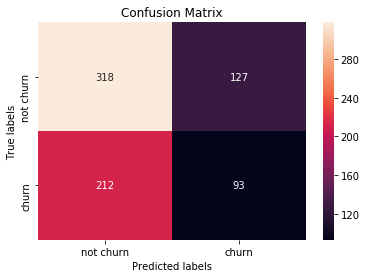

In [49]:
plot_confusion_matrix()
